Version 1.0.1

# Check your versions

In [3]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.15.2
pandas 0.20.3
scipy 0.19.1
sklearn 0.19.0
lightgbm 2.0.6


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [6]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [7]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

And use only 3 shops for simplicity.

In [8]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [9]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/home/cgebbe/anaconda3/envs/coursera_winkaggle2/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [10]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

/home/cgebbe/anaconda3/envs/coursera_winkaggle2/lib/python3.5/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [31]:
all_data.head(5) # date_block_num in [12,33]

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [89]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [90]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [91]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And the we run *LightGBM*.

In [92]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Finally, concatenate test predictions to get test meta-features.

In [93]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 
print(pred_lr.shape)
print(X_test_level2.shape)

(3354,)
(3354, 2)


### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [37]:
mask = dates_train.isin([27, 28, 29, 30, 31, 32])
dates_train_level2 = dates_train[mask]
y_train_level2 = y_train[mask]
print(dates_train_level2.shape)
print(y_train_level2.shape)
dates_train_level2.head()

(34404,)
(34404,)


120192    27
120193    27
120194    27
120195    27
120196    27
Name: date_block_num, dtype: int32

In [ ]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    print(cur_block_num)
    
    # 1. split X_train into parts
    last_block = cur_block_num
    dates_train = dates[dates <  last_block]
    dates_test  = dates[dates == last_block]
    X_train2 = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
    X_test2 =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
    y_train2 = all_data.loc[dates <  last_block, 'target'].values
    y_test2 =  all_data.loc[dates == last_block, 'target'].values
    
    # 2,3. Fit LR and LightGBM
    lr = LinearRegression()
    lr.fit(X_train2.values, y_train2)
    pred_lr = lr.predict(X_test2.values)
    model = lgb.train(lgb_params, lgb.Dataset(X_train2, label=y_train2), 100)
    pred_lgb = model.predict(X_test2)
    X_test_level2 = np.c_[pred_lr, pred_lgb] 
    
    # 4. Store at right place
    mask = dates_train_level2 == cur_block_num
    X_train_level2[mask, : ] = X_test_level2
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    

In [42]:
# Sanity check
if np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989])):
    print("Hooray, correct")
else:
    print("boo, bad")

Hooray, correct


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

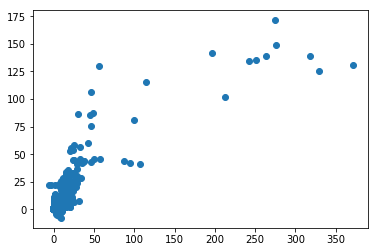

In [43]:
plt.scatter(X_train_level2[:,0], X_train_level2[:,1])

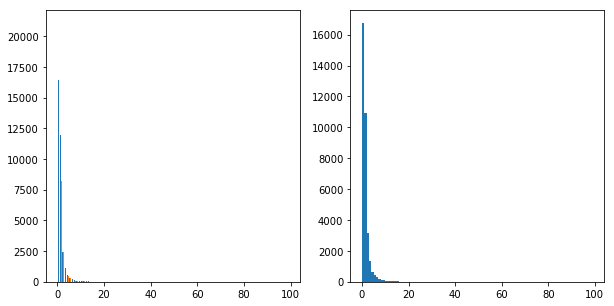

In [53]:
fig,axes = plt.subplots(1,2, figsize=(10,5))
_ = axes[0].hist(X_train_level2, bins=np.arange(0,100))
_ = axes[1].hist(y_train_level2, bins=np.arange(0,100))

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [55]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = None
best_r2 = 0
for a in alphas_to_try:
    y = X_train_level2[:,0] * a + X_train_level2[:,1] * (1-a)
    r2 = r2_score(y_train_level2, y)
    if r2>best_r2:
        best_r2=r2
        best_alpha=a
        print("Found better a={} yielding r2={}".format(a, r2))
    
r2_train_simple_mix = best_r2
print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Found better a=0.0 yielding r2=0.4710187874149271
Found better a=0.001 yielding r2=0.47142713181186047
Found better a=0.002 yielding r2=0.47183494187895925
Found better a=0.003 yielding r2=0.4722422176162233
Found better a=0.004 yielding r2=0.47264895902365245
Found better a=0.005 yielding r2=0.47305516610124676
Found better a=0.006 yielding r2=0.47346083884900647
Found better a=0.007 yielding r2=0.47386597726693136
Found better a=0.008 yielding r2=0.4742705813550213
Found better a=0.009000000000000001 yielding r2=0.47467465111327634
Found better a=0.01 yielding r2=0.47507818654169687
Found better a=0.011 yielding r2=0.47548118764028247
Found better a=0.012 yielding r2=0.47588365440903324
Found better a=0.013000000000000001 yielding r2=0.4762855868479493
Found better a=0.014 yielding r2=0.47668698495703044
Found better a=0.015 yielding r2=0.47708784873627696
Found better a=0.016 yielding r2=0.47748817818568856
Found better a=0.017 yielding r2=0.47788797330526533
Found better a=0.018000

Found better a=0.404 yielding r2=0.5924922692445425
Found better a=0.405 yielding r2=0.5926847443882177
Found better a=0.406 yielding r2=0.5928766852020582
Found better a=0.40700000000000003 yielding r2=0.5930680916860638
Found better a=0.40800000000000003 yielding r2=0.5932589638402346
Found better a=0.40900000000000003 yielding r2=0.5934493016645705
Found better a=0.41000000000000003 yielding r2=0.593639105159072
Found better a=0.41100000000000003 yielding r2=0.5938283743237385
Found better a=0.41200000000000003 yielding r2=0.5940171091585702
Found better a=0.41300000000000003 yielding r2=0.594205309663567
Found better a=0.41400000000000003 yielding r2=0.5943929758387291
Found better a=0.41500000000000004 yielding r2=0.5945801076840564
Found better a=0.41600000000000004 yielding r2=0.5947667051995489
Found better a=0.417 yielding r2=0.5949527683852067
Found better a=0.418 yielding r2=0.5951382972410295
Found better a=0.419 yielding r2=0.5953232917670176
Found better a=0.42 yielding r

Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [94]:
test_preds = X_test_level2[:,0] * best_alpha + X_test_level2[:,1] * (1-best_alpha)
print(test_preds.shape)
print(y_test.shape)
r2_test_simple_mix = r2_score(y_test,test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

(3354,)
(3354,)
Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [66]:
lr_lvl2 = LinearRegression()
lr_lvl2.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [95]:
train_preds = lr_lvl2.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr_lvl2.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [96]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.6272550434461521
Current answer for task r2_test_simple_mix is: 0.7811441695790362
Current answer for task r2_train_stacking is: 0.6321755614590683
Current answer for task r2_test_stacking is: 0.771297132342246


In [97]:
STUDENT_EMAIL = 'christian.gebbe@gmail.com'
STUDENT_TOKEN = 'zgfMY8gzGS5jxsFB'
grader.status()

You want to submit these numbers:
Task best_alpha: 0.765
Task r2_train_simple_mix: 0.6272550434461521
Task r2_test_simple_mix: 0.7811441695790362
Task r2_train_stacking: 0.6321755614590683
Task r2_test_stacking: 0.771297132342246


In [98]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
